## **Part 2: A Continuous-Time Model**

In [2]:
# Plotting
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import plotly.io as pio
import matplotlib.pyplot as plt
#pio.renderers.default = "notebook+pdf"
#pio.templates.default = "plotly_dark"

# Utilities
import numpy as np
import scipy.linalg as la

### **Task 7**

In [3]:
Q = np.array([
    [-0.0085, 0.005, 0.0025, 0, 0.001],
    [0, -0.014, 0.005, 0.004, 0.005],
    [0, 0, -0.008, 0.003, 0.005],
    [0, 0, 0, -0.009, 0.009],
    [0, 0, 0, 0, 0]
])
Qs = Q[:-1, :-1]
Qdiag = np.diag(Q)
stateDescs = ['Starting State', 'Local Recurrence', 'Distant Metastasis', 'Both Local and Distant', 'Death']

def changeState(Q, state, currentTime, endTime):
    if state == 4:
        return endTime, 4
    qii = Q[state,state]
    if qii == 0:
        return endTime, state
    time = np.random.exponential(-(1/qii))
    if currentTime + time > endTime:
        return endTime - currentTime, state
    # Determine the next state
    ps = np.copy(Q[state, :])
    ps[state] = 0
    ps /= -qii
    ps[state] = 1 - sum(ps)
    nextState = np.random.choice(range(5), p=ps)
    return time, nextState

def simulateWoman(Q, startingState, endTime):
    state = startingState
    time = 0
    times = [0]
    states = [state]
    while state != 4 and time < endTime:
        dt, state = changeState(Q, state, time, endTime)
        time += dt
        times.append(time)
        states.append(state)
    return np.array(times), np.array(states)

def simulateWomen(Q, n, startingStates, endTime):
    women = []
    for i in range(n):
        times, states = simulateWoman(Q, startingStates[i], endTime)
        women.append((times, states))
    return women




#### **Analyzing state distribution after 30.5 months**

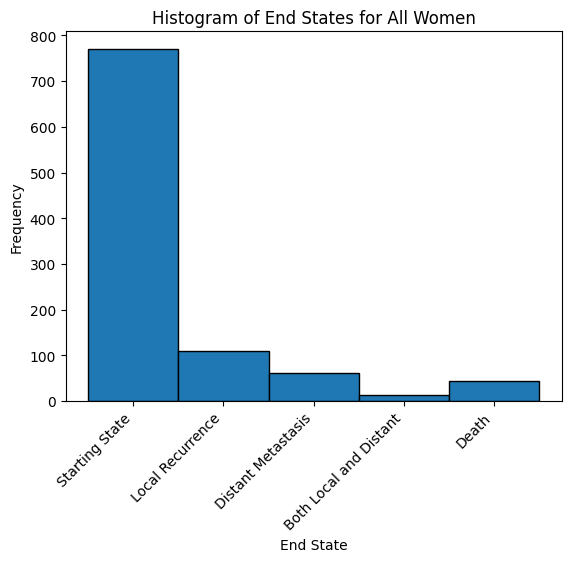

7.6% of women had a distant reappearence of breast cancer


In [4]:
n = 1000
endTime = 30.5
startingStates = np.zeros(n, dtype=int)
womenTask7 = simulateWomen(Q, n, startingStates, endTime)

# Make histogram of end states for all women
endStates = np.array([woman[1][-1] for woman in womenTask7], dtype=int)
plt.hist(endStates, bins=np.arange(0,6), edgecolor='black')
plt.title('Histogram of End States for All Women')
plt.xlabel('End State')
plt.ylabel('Frequency')
plt.xticks(ticks=np.arange(0, 5)+0.5, labels=stateDescs, rotation=45, ha="right")
plt.show()

histogram = np.histogram(endStates, bins=np.arange(0,6))[0]
print(f"{(histogram[2] + histogram[3]) / n * 100}% of women had a distant reappearence of breast cancer")

#### **Summary of liftime distribution after surgery**

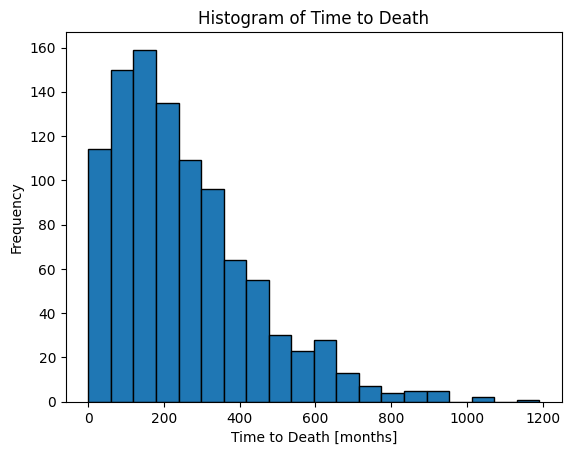

In [5]:
n = 1000
endTime = np.inf
startingStates = np.zeros(n, dtype=int)
women = simulateWomen(Q, n, startingStates, endTime)

# Time histogram
times = np.array([woman[0][-1] for woman in women], dtype=int)
plt.hist(times, bins=20, edgecolor='black')
plt.title('Histogram of Time to Death')
plt.xlabel('Time to Death [months]')
plt.ylabel('Frequency')
plt.show()

#### **Getting a mean lifetime after surgery**

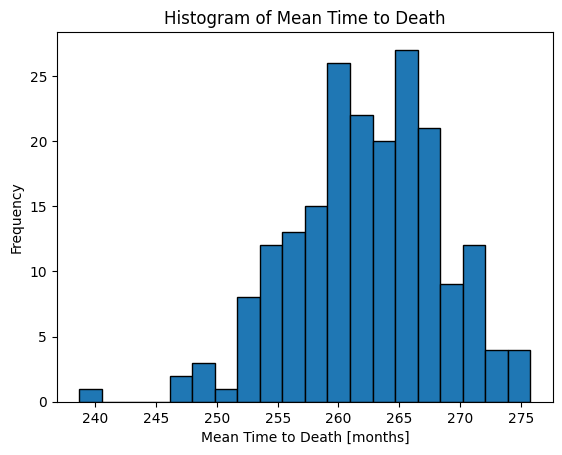

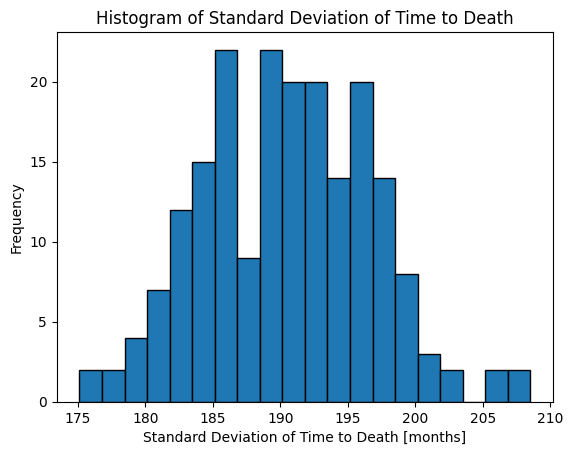

In [6]:
m = 200
means = []
sds = []
for i in range(m):
    women = simulateWomen(Q, n, startingStates, endTime)
    times = np.array([woman[0][-1] for woman in women], dtype=int)
    means.append(np.mean(times))
    sds.append(np.std(times))
plt.hist(means, bins=20, edgecolor='black')[0]
plt.title('Histogram of Mean Time to Death')
plt.xlabel('Mean Time to Death [months]')
plt.ylabel('Frequency')
plt.show()

plt.hist(sds, bins=20, edgecolor='black')
plt.title('Histogram of Standard Deviation of Time to Death')
plt.xlabel('Standard Deviation of Time to Death [months]')
plt.ylabel('Frequency')
plt.show()

In [7]:
print(f"Mean time to death: {round(np.mean(means),1)} months")
print(f"95% confidence interval for mean lifetime: {np.percentile(means, [2.5, 97.5])}")
print(f"Mean standard deviation of time to death: {round(np.mean(sds),1)} months")
print(f"95% confidence interval for standard deviation of lifetime: {np.percentile(sds, [2.5, 97.5])}")

Mean time to death: 262.2 months
95% confidence interval for mean lifetime: [248.965675 272.93515 ]
Mean standard deviation of time to death: 190.5 months
95% confidence interval for standard deviation of lifetime: [179.06251539 202.2165418 ]


### **Task 8**
Compare the emperical lifetime distribution function, from your simulations,
to the theoretical, using an appropriate statistical test.

We'll use the Kolmogorov Smirnov test to test the theoretical lifetim distribution to the simulated lifetime distribution. This is done by just running the simulation, untill all women in the group are dead. 

In [8]:
# Theoretical lifetime distribution
def Ft(t, p0):
    F = 1 - p0 @ la.expm(Qs * t) @ np.ones(4)
    return F

endTime = np.inf
n = 1000
startingStates = np.zeros(n, dtype=int)
women = simulateWomen(Q, n, startingStates, endTime)
p0 = np.array([1, 0, 0, 0])

# KS test
deathTimes = []
for w in women:
    deathTimes.append(w[0][-1])

deathTimes = np.array(deathTimes)
deathTimes = np.sort(deathTimes)
# get the empirical CDF
n = len(deathTimes)
Fs = np.arange(1, n+1) / n
# Theoretical CDF
FsTrue= []
for t in deathTimes:
    FsTrue.append(Ft(t, p0))
FsTrue = np.array(FsTrue)

Plotting the theoretical and simulated CDF's reveals that they are as expected quite similar. The KS-test gives a p-value of $\approx 0.88$, suggesting that we can not tell the difference, between the two CDF's.

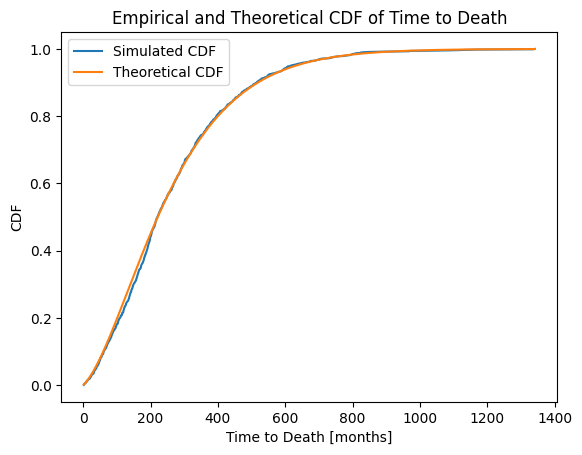

KS test statistic: 0.03252991357899615
p-value: 0.8795343410835974


In [10]:
plt.plot(deathTimes, Fs, label='Empirical CDF')
plt.plot(deathTimes, FsTrue, label='Theoretical CDF')
plt.legend(['Simulated CDF', 'Theoretical CDF'])
plt.title('Empirical and Theoretical CDF of Time to Death')
plt.xlabel('Time to Death [months]')
plt.ylabel('CDF')
plt.show()

# KS test
D = np.max(np.abs(Fs - FsTrue))
print(f"KS test statistic: {D}")
pval = 1 - np.exp(-2*n*D**2)
print(f"p-value: {pval}")

### **Task 9**

In [57]:
from sksurv.nonparametric import kaplan_meier_estimator
QTreat = np.array([
    [-0.00475,0.0025, 0.00125, 0, 0.001],
    [0, -0.007,0 , 0.002, 0.005],
    [0, 0, -0.008 , 0.003, 0.005],
    [0, 0, 0, -0.009, 0.009],
    [0, 0, 0, 0, 0]
])

n = 1000
startingStates = np.zeros(n, dtype=int)
endTime = 300
women = simulateWomen(Q, n, startingStates, endTime)
womenTreat = simulateWomen(QTreat, n, startingStates, endTime)

# Set up data to be used in the Kaplan-Meier estimator
times = np.zeros(n)
status = np.zeros(n, dtype=bool)
timesTreat = np.zeros(n)
statusTreat = np.zeros(n, dtype=bool)
for i in range(n):
    w = women[i]
    times[i] = w[0][-1]
    status[i] = w[1][-1] == 4
    wTreat = womenTreat[i]
    timesTreat[i] = wTreat[0][-1]
    statusTreat[i] = wTreat[1][-1] == 4



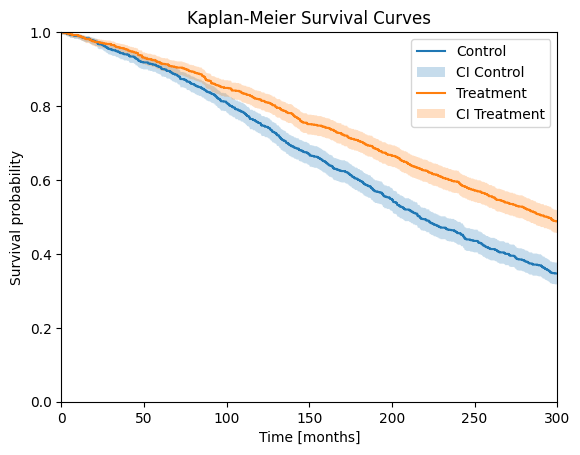

In [58]:
# Kaplan-Meier estimator
time, survival_prob, conf_int = kaplan_meier_estimator(
    status, times, conf_type="log-log"
)
timeTreat, survival_probTreat, conf_intTreat = kaplan_meier_estimator(
    statusTreat, timesTreat, conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.step(timeTreat, survival_probTreat, where="post")
plt.fill_between(timeTreat, conf_intTreat[0], conf_intTreat[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel("Survival probability")
plt.xlim(0, 300)
plt.xlabel("Time [months]")
plt.legend(['Control','CI Control', 'Treatment','CI Treatment'])
plt.title('Kaplan-Meier Survival Curves')
plt.show()

### **Task 10**
Log-rank test

In [82]:


times1 = np.copy(times)
times2 = np.copy(timesTreat)
times1 = np.sort(times1)
times2 = np.sort(times2)
J = len(times1) + len(times2)
lastTime = J + 1
N1s = [n]
N2s = [n]
O1s = [0]
O2s = [0]


group1idx = 0
group2idx = 0

for i in range(1,lastTime):
    if group1idx >= len(status):
        nextEvent = np.inf
    else:
        nextEvent = times1[group1idx]
    if group2idx >= len(statusTreat):
        nextEvent2 = np.inf
    else:
        nextEvent2 = times2[group2idx]
    if nextEvent < nextEvent2:
        if nextEvent < endTime:
            N1s.append(N1s[i-1] - 1)
            O1s.append(O1s[i-1] + 1)
            N2s.append(N2s[i-1])
            O2s.append(O2s[i-1]) 
        group1idx += 1
    else:
        if nextEvent2 < endTime:
            N2s.append(N2s[i-1] - 1)
            O2s.append(O2s[i-1] + 1)
            N1s.append(N1s[i-1])
            O1s.append(O1s[i-1])
        group2idx += 1

Ns = np.array(N1s) + np.array(N2s)
Os = np.array(O1s) + np.array(O2s)

In [83]:
V1 = np.zeros(len(Os))
V2 = np.zeros(len(Os))
E1s = np.zeros(len(Os))
E2s = np.zeros(len(Os))

for i in range(len(Os)):
    E1s[i] = Os[i] * N1s[i] / Ns[i]
    E2s[i] = Os[i] * N2s[i] / Ns[i]
    V1[i] = E1s[i]*((Ns[i] - Os[i]) / Ns[i]) * ((Ns[i] - N1s[i]) / (Ns[i] - 1))
    V2[i] = E2s[i]*((Ns[i] - Os[i]) / Ns[i]) * ((Ns[i] - N2s[i]) / (Ns[i] - 1))


In [85]:
Z1 = sum(O1s - E1s) / np.sqrt(sum(V1))
Z2 = sum(O2s - E2s) / np.sqrt(sum(V2))

# Compare the Z's to a standard normal distribution
# If they are greater than 1.96, we reject the null hypothesis that the two groups are the same
print(f"Z1: {Z1}")
print(f"Z2: {Z2}")
# There's a difference with the treatment group



Z1: 371.76270120188207
Z2: -371.7627012018822


### **Task 11**

What assumptions have been eliminated here, compared to in the discrete time model?

What assumptions have been added, compared to the discrete time model?

Get the time a patiant is in a state $X\in \{1,\dots 5\}$ to be Erlang distributed, as opposed to exponentially distributed

Mean value of $Erlang _n$ distribution is $\frac{n}{\lambda}$

We want to continue having the same mean rate of state changes

Decide on which $n$ to use. Then choose a rate for the Erlang distributions according to

$$\frac{n}{\lambda_{erlang}}  = \frac{1}{\lambda} \Leftrightarrow \lambda_{erlang} = n \lambda. $$

For the diaginal in $Q$ this means

$$q_{i,i.erlang} = n \cdot q_{i,i}.$$

Correction for the the rest of the rates in Q should also be made. Assuming we want the same probabilities as earlier the matrix $Q$ for an $Erlang _n$ distribution is

$$ Q_{erlang.n} =  \begin{bmatrix}     
    -0.0085\cdot n & 0.005 \cdot n & 0.0025 \cdot n & 0 & 0.001\cdot n \\
    0 & -0.014\cdot n & 0.005 \cdot n & 0.004 \cdot n& 0.005 \cdot n \\
    0 & 0 & -0.008\cdot n & 0.003\cdot n& 0.005\cdot n \\
    0 & 0 & 0 & -0.009 \cdot n& 0.009\cdot n \\
    0 & 0& 0& 0& 0
\end{bmatrix}  = Q \cdot n$$

In [152]:

Q = np.array(
    [[-0.0085, 0.005, 0.0025, 0, 0.001],
    [0, -0.014, 0.005, 0.004, 0.005],
    [0, 0, -0.008, 0.003, 0.005],
    [0, 0, 0, -0.009, 0.009],
    [0, 0, 0, 0, 0]])

def Erlang(lam, n):
    return sum(np.random.exponential(-1/lam, n))

def changeStateErlang(Q, state, currentTime, endTime, n):
    if state == 4:
        return endTime, 4
    qii = Q[state,state]
    if qii == 0:
        return endTime, state
    time = Erlang(qii, n)
    if currentTime + time > endTime:
        return endTime - currentTime, state
    # Determine the next state
    ps = np.copy(Q[state, :])
    ps[state] = 0
    ps /= -qii
    ps[state] = 1 - sum(ps)
    nextState = np.random.choice(range(5), p=ps)
    return time, nextState

def simulateWomanErlang(Q, startingState, endTime, n):
    state = startingState
    time = 0
    times = [0]
    states = [state]
    while state != 4 and time < endTime:
        dt, state = changeStateErlang(Q, state, time, endTime, n)
        time += dt
        times.append(time)
        states.append(state)
    return np.array(times), np.array(states)

def simulateWomenErlang(Q, m, startingStates, endTime, n):
    women = []
    Q_real = Q * n
    #print(Q_real)
    for i in range(m):
        times, states = simulateWomanErlang(Q_real, startingStates[i], endTime, n)
        women.append((times, states))
    return women



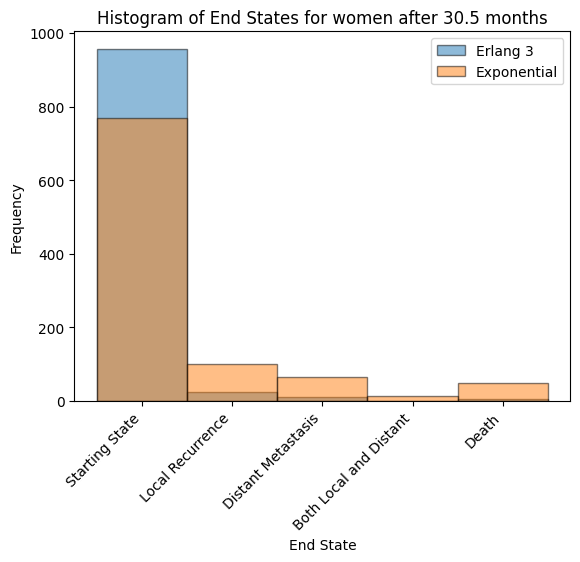

1.2% of women had a distant reappearence of breast cancer in the Erlang 3 model
8.0% of women had a distant reappearence of breast cancer in the Exponential model


In [156]:
m = 1000
n = 3
endTime = 30.5
startingStates = np.zeros(m, dtype=int)
womenErlang = simulateWomenErlang(Q, m, startingStates, endTime , n)

# Make histogram of end states for all women
endStatesErlang = np.array([woman[1][-1] for woman in womenErlang], dtype=int)
plt.hist(endStatesErlang, bins=np.arange(0,6), edgecolor='black', alpha = 0.5, label = 'Erlang ' + str(n))
plt.title('Histogram of End States for All Women')
plt.xlabel('End State')
plt.ylabel('Frequency')
plt.xticks(ticks=np.arange(0, 5)+0.5, labels=stateDescs, rotation=45, ha="right")
# plt.show()
plt.hist(endStates, bins=np.arange(0,6), edgecolor='black', alpha = 0.5, label = 'Exponential')
plt.title('Histogram of End States for women after 30.5 months')
plt.xlabel('End State')
plt.ylabel('Frequency')
plt.xticks(ticks=np.arange(0, 5)+0.5, labels=stateDescs, rotation=45, ha="right")
plt.legend()
plt.show()


histogramErlang = np.histogram(endStatesErlang, bins=np.arange(0,6))[0]
print(f"{round((histogramErlang[2] + histogramErlang[3]) / m * 100,2)}% of women had a distant reappearence of breast cancer in the Erlang {n} model")
print(f"{round((histogram[2] + histogram[3]) / m * 100,2)}% of women had a distant reappearence of breast cancer in the Exponential model")